In [2]:
# Importando bibliotecas

import femder as fd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
from femder.FEM_3D import  p2SPL

In [43]:
import pickle
with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\fluido_eq\\obj_150_600_1.pkl","rb") as arquivo:
  obj1 = pickle.load(arquivo)

with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\fluido_eq\\obj_601_1k_1.pkl","rb") as arquivo:
  obj2 = pickle.load(arquivo)

with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\fluido_eq\\obj_1001_2k_1.pkl","rb") as arquivo:
  obj3 = pickle.load(arquivo)

# with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\fluido_eq\\obj_FF.pkl","rb") as arquivo:
#   obj1_FF = pickle.load(arquivo)

# with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\fluido_eq\\obj601-1k_FF.pkl","rb") as arquivo:
#   obj2_FF = pickle.load(arquivo)

# with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\fluido_eq\\obj1k-2k_FF.pkl","rb") as arquivo:
#   obj3_FF = pickle.load(arquivo)

In [3]:
import numpy as np

tel=obj3.c0/(6*500) # ok tamanho de elemento
qsi1=0; qsi2=0; qsi3=0; # primeiro nó do elemento padrao (TET10)
ind = np.argwhere(obj3.domain_index_surf==8)[:,0]
con = obj3.elem_surf[ind,:] # use unique p pegar os nós da superficie e as coord
coord_mat = obj3.nos[np.unique(con),:] #p freq mais alta


#coord_mat = coord_tag6[0,:]#coord_u _ coordenada do ponto de velocidade que se quer calcular

In [44]:
# grid de coordenadas 
d=0
x = np.linspace(0.4925+d,0.9075-d,80)
y = np.linspace(0.459+d,0.874-d,80)
z = 0.025
coord_u = np.zeros((len(x)*len(y),3))
n=0
for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        coord_u[n,:] = np.array([x[i],y[j],z])
        n+=1
        
print(coord_u)

[[0.4925     0.459      0.025     ]
 [0.4925     0.46425316 0.025     ]
 [0.4925     0.46950633 0.025     ]
 ...
 [0.9075     0.86349367 0.025     ]
 [0.9075     0.86874684 0.025     ]
 [0.9075     0.874      0.025     ]]


In [16]:
obj2_FF.freq[-1]

1000

In [45]:
def impedancia_u(tel,coord_u,obj):
  
  qsi1=0; qsi2=0; qsi3=0; # primeiro nó do elemento padrao (TET10)
    #função de forma T10 - Ziekwineski OKOK - CORRIGIDO e verificado COM Figura "tetra_Zienkiewicz_TET10_.png" (*)
  N = np.array([[(1-qsi1-qsi2-qsi3)*(2*(1-qsi1-qsi2-qsi3)-1)],
               [qsi1*(2*qsi1-1)],
               [qsi2*(2*qsi2-1)],
               [qsi3*(2*qsi3-1)],
               [4*qsi1*(1-qsi1-qsi2-qsi3)],
               [4*qsi1*qsi2],
               [4*qsi2*(1-qsi1-qsi2-qsi3)],
               [4*qsi3*(1-qsi1-qsi2-qsi3)],
               [4*qsi3*qsi1],
               [4*qsi2*qsi3]])
  # derivada da função de forma T10 - Ziekwineski OKOK - refeita, de acordo COM Figura "tetra_Zienkiewicz_TET10_.png"
  GNi= np.array([[4*qsi1 + 4*qsi2 + 4*qsi3 - 3, 4*qsi1 - 1, 0, 0, 4 - 4*qsi2 - 4*qsi3 - 8*qsi1, 4*qsi2, -4*qsi2, -4*qsi3, 4*qsi3, 0],
               [4*qsi1 + 4*qsi2 + 4*qsi3 - 3, 0, 4*qsi2 - 1, 0, -4*qsi1, 4*qsi1, 4 - 8*qsi2 - 4*qsi3 - 4*qsi1, -4*qsi3, 0, 4*qsi3],
               [4*qsi1 + 4*qsi2 + 4*qsi3 - 3, 0, 0, 4*qsi3 - 1, -4*qsi1, 0, -4*qsi2, 4 - 4*qsi2 - 8*qsi3 - 4*qsi1, 4*qsi1, 4*qsi2]])
  
  if coord_u.shape[0]>1:
    Zs_u = np.zeros((coord_u.shape[0],len(obj.freq)), dtype = np.cfloat)
    for l in range(coord_u.shape[0]):
      coord_el_med=np.array([[0,0,0],
                       [1,0,0],
                       [0,1,0],
                       [0,0,1],
                       [0.5,0,0],
                       [0.5,0.5,0],
                       [0,0.5,0],
                       [0,0,0.5],
                       [0.5,0,0.5],
                       [0,0.5,0.5]])
      coord_el_med=coord_el_med-np.array([qsi1,qsi2,qsi3])  # translação necessária no espaço
      coord_el_med=coord_el_med*tel+coord_u[l,:]#coord_mat[0,:] # translação necessária no espaço com elemento redimensionado
      R = fd.Receiver()
      R.coord = coord_el_med
      obj.evaluate(R);
      ## Jacobiano e derivada da pressão
      Ja = GNi@coord_el_med
      B = (np.linalg.inv(Ja)@GNi) # compute the B matrix - B é o gradiente
      p_total_nodais = obj.pR.T # PRESSÃO NOS n nós do elemento de volume
      delPmed=B@p_total_nodais# para todas as frequencias fazer um for, ver como fazer operando matrizes
      pmed=p_total_nodais*N # calculada na coordenada qsi1 qsi2 qsi3   # 
      dir = np.array([0,0,1]).reshape((1,3))
      delPmed1 = dir@delPmed
      u=(delPmed1)/(1j*obj.w*obj.rho0) # convençãao exp(-j\omega t)
      Zs_u[l,:]=pmed[0]/(u) # IMPEDANCIA
  else:
    coord_el_med=np.array([[0,0,0],
                       [1,0,0],
                       [0,1,0],
                       [0,0,1],
                       [0.5,0,0],
                       [0.5,0.5,0],
                       [0,0.5,0],
                       [0,0,0.5],
                       [0.5,0,0.5],
                       [0,0.5,0.5]])
    coord_el_med=coord_el_med-np.array([qsi1,qsi2,qsi3])  # translação necessária no espaço
    coord_el_med=coord_el_med*tel+coord_u#coord_mat[0,:] # translação necessária no espaço com elemento redimensionado
    R = fd.Receiver()
    R.coord = coord_el_med
    obj.evaluate(R);
    # Jacobiano e derivada da pressão
    Ja = GNi@coord_el_med
    B = (np.linalg.inv(Ja)@GNi) # compute the B matrix - B é o gradiente
    p_total_nodais = obj.pR.T # PRESSÃO NOS n nós do elemento de volume
    delPmed=B@p_total_nodais# para todas as frequencias fazer um for, ver como fazer operando matrizes
    pmed=p_total_nodais*N # calculada na coordenada qsi1 qsi2 qsi3   # 
    dir = np.array([0,0,-1]).reshape((1,3))
    delPmed1 = dir@delPmed
    u=(delPmed1)/(1j*obj.w*obj.rho0) # convençãao exp(-j\omega t)
    Zs_u=pmed[0]/(u) # IMPEDANCIA

  return Zs_u

In [46]:

import scipy.io as sio

q = sio.loadmat(r'G:\\Meu Drive\\TCC\\Simulacao_computacional\\Qi.mat')
# sorted(q.keys())
q = q['Qi']
path_to_geo = "G:\Meu Drive\TCC\Simulacao_computacional\codes\geo\material_maisEspesso\minicamara_modificada_fonte_volmat2.geo"

AP = fd.AirProperties(c0 = 343)
fmax = 2000 #2300
fmin = 150
AC = fd.AlgControls(AP,fmin,fmax,1)
S = fd.Source("spherical")
S.coord = np.array([[1.222,0.15,0.1]])
S.q = np.array(q.T.ravel())
BC = fd.BC(AC,AP) #[2,3,4,5,6,7]
#BC.normalized_admittance(6,sup.admittance)
BC.delany(6,RF=12100, d=0.025, model='miki')

In [47]:
# Para cada faixa de freq simulada, a func calcula p os mesmos pontos no espaço, 
#modificando o elemento padrão de acordo com a freq max da simu
Zs_u1 = impedancia_u(343/(6*500), coord_u, obj1);
Zs_u2 = impedancia_u(343/(6*900), coord_u, obj2);
Zs_u3 = impedancia_u(343/(6*2000), coord_u, obj3);
# Zs_u1FF = impedancia_u(343/(6*600), coord_u, obj1_FF);
# Zs_u2FF = impedancia_u(343/(6*1000), coord_u, obj2_FF);
# Zs_u3FF = impedancia_u(343/(6*2000), coord_u, obj3_FF);

In [51]:
R = fd.Receiver()
R.coord = coord_u
grid = fd.GridImport3D(AP,path_to_geo,S,R,fmax = fmax,num_freq=6,scale=1000,order=1,load_method='meshio')
obj = fd.FEM3D(grid,S,R,AP,AC,BC)
obj.plot_problem(renderer='browser',saveFig=False,camera_angles=['diagonal_front'],extension='png')

In [48]:
Zs_DBM = 1/BC.mu[6]

In [49]:

#Zs_uFF = np.concatenate((Zs_u1FF,Zs_u2FF[:,1:],Zs_u3FF[:,1:]),axis=1)
Zs_u = np.concatenate((Zs_u1,Zs_u2,Zs_u3),axis=1)
#pR = np.concatenate((obj1.pR,obj2.pR[1:,:],obj3.pR[1:,:]))
Zs_uMED = np.mean(Zs_u, axis=0)
#Zs_uMEDFF = np.mean(Zs_uFF, axis=0)

In [59]:
# Salva var
import pickle
with open("G:\\Meu Drive\\TCC\\Simulacao_computacional\\minicamara-90mm\\minicamara_comMat\\espessura2_5cm\\fluido_eq\\Zs_uFF.pkl", "wb") as arquivo:
    pickle.dump(Zs_uFF, arquivo)

In [55]:
from scipy.io import savemat
#savemat('G:\Meu Drive\TCC\Simulacao_computacional\minicamara_comMat\espessura2_5cm\Zs_DBM_cte0_004_RIs_simuladas.mat',{'RIs':ir,'freq':AC.freq})
savemat('G:\\Meu Drive\\TCC\\Simulacao_computacional\\Zs_DBM.mat',{'Zs_DBM':Zs_DBM})


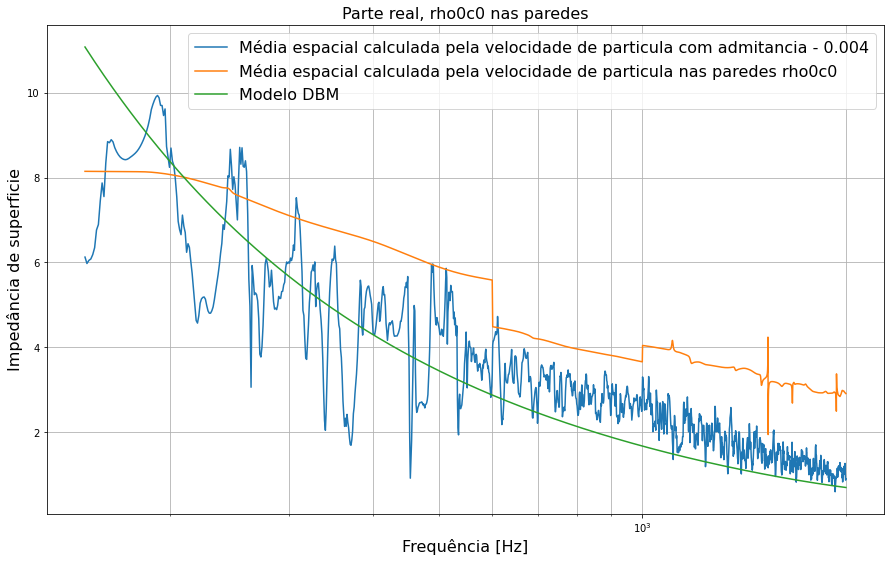

In [51]:
zar = AP.c0*AP.rho0
plt.figure(figsize=(15,9)) # ver tese do eric
# for i in range(Zs_u.shape[0]):
#     plt.semilogx(AC.freq, abs(Zs_u[i,:]), label=f'rec {i}')
plt.title('Parte real, rho0c0 nas paredes', fontsize=16)
plt.semilogx(AC.freq, np.real(abs(Zs_uMED/zar)), label='Média espacial calculada pela velocidade de particula com admitancia - 0.004')
plt.semilogx(AC.freq, np.real(abs(Zs_uMEDFF/zar)), label='Média espacial calculada pela velocidade de particula nas paredes rho0c0')
plt.semilogx(AC.freq, np.real(abs(Zs_DBM/zar)), label='Modelo DBM')
# plt.xlim(500, 2000)
#plt.ylim(0, 6)
plt.xlabel('Frequência [Hz]', fontsize=16)
# plt.ylabel(r'Impedância de superficie normalizada - Z$_{ar}$', fontsize=16)
plt.ylabel('Impedância de superficie', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True,which="both")
# plt.savefig('G:\\Meu Drive\\TCC\\resultados\\compara_ZsDBM_Z_velp_real_rho0c01.png')
plt.show()

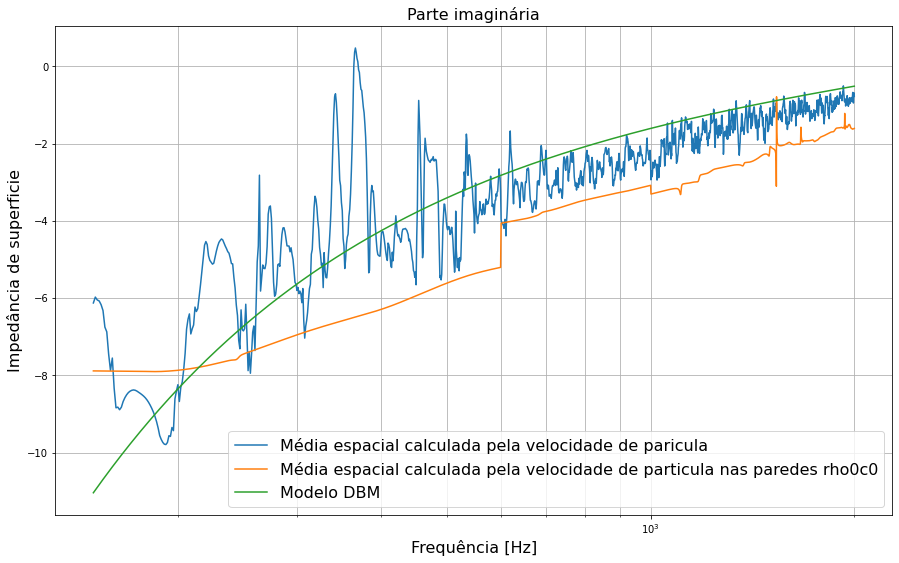

In [52]:
plt.figure(figsize=(15,9)) # ver tese do eric
# for i in range(Zs_u.shape[0]):
#     plt.semilogx(AC.freq, abs(Zs_u[i,:]), label=f'rec {i}')
plt.title('Parte imaginária', fontsize=16)
plt.semilogx(AC.freq, np.imag((Zs_uMED/zar)), label='Média espacial calculada pela velocidade de paricula')
plt.semilogx(AC.freq, np.imag((Zs_uMEDFF/zar)), label='Média espacial calculada pela velocidade de particula nas paredes rho0c0')
plt.semilogx(AC.freq, np.imag((Zs_DBM/zar)), label='Modelo DBM')
# plt.xlim(500, 2000)
#plt.ylim(-11, 0)
plt.xlabel('Frequência [Hz]', fontsize=16)
# plt.ylabel(r'Impedância de superficie normalizada - Z$_{ar}$', fontsize=16)
plt.ylabel('Impedância de superficie', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True,which="both")
#plt.savefig('G:\\Meu Drive\\TCC\\resultados\\compara_ZsDBM_Z_velp_imag_rho0c0.png')
plt.show()

In [44]:
Z_1k =Zs_u3[:,1099].reshape((70,70))/zar

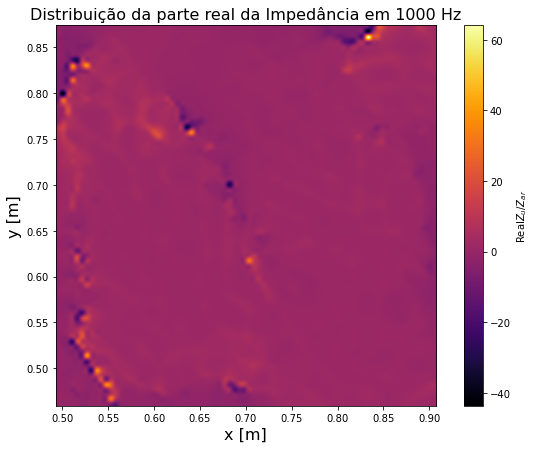

In [55]:
from matplotlib import cm
# plt.figure(figsize=(15,9)) 
# # for i in range(Zs_u.shape[0]):
# #     plt.semilogx(AC.freq, abs(Zs_u[i,:]), label=f'rec {i}')
# ax = plt.axes()
# ax.imshow(abs(Zs_u3[:,200].reshape((70,70))), cmap=cm.coolwarm, \
#           extent=(0,41.5,0,41.5), interpolation='bilinear')
# ax.colormap()
# ax.set_xlabel('eixo x (cm)')
# ax.set_ylabel('eixo y (cm)')

plt.figure(figsize=(10,7))
plt.imshow(np.real((Zs_u2[:,-1].reshape((80,80))/zar)), vmin = np.min(np.real((Zs_u2[:,-1].reshape((80,80))/zar))), vmax = np.max(np.real(((Zs_u2[:,-1].reshape((80,80))/zar)))),origin='upper', extent=[x.min(),x.max(),y.min(),y.max()], cmap='inferno', interpolation='spline36')
plt.colorbar(label=r'Real$Z_{u}/Z_{ar}$')
plt.title(f'Distribuição da parte real da Impedância em {obj2.freq[-1]} Hz',fontsize=16)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.legend
plt.show()

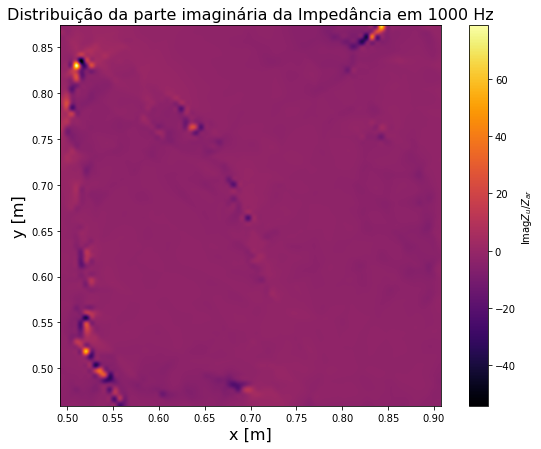

In [57]:
plt.figure(figsize=(10,7))
plt.imshow(np.imag((Zs_u2[:,-1].reshape((80,80))/zar)), vmin = np.min(np.imag((Zs_u2[:,-1].reshape((80,80))/zar))), vmax =np.max(np.imag((Zs_u2[:,-1].reshape((80,80))/zar))),origin='upper', extent=[x.min(),x.max(),y.min(),y.max()], cmap='inferno', interpolation='spline36')
plt.colorbar(label=r'Imag$Z_{u}/Z_{ar}$')
plt.title(f'Distribuição da parte imaginária da Impedância em {obj2.freq[-1]} Hz',fontsize=16)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.legend
plt.show()

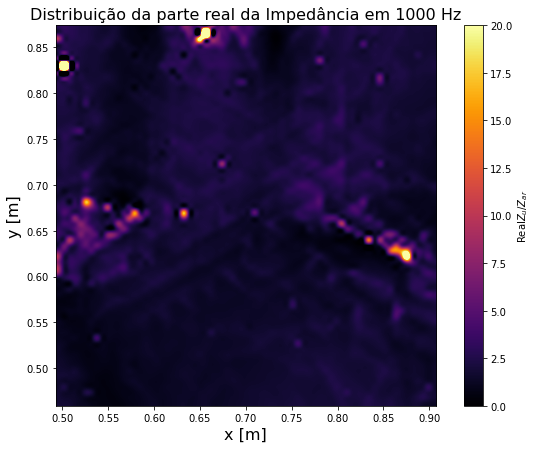

In [71]:
plt.figure(figsize=(10,7))
plt.imshow(np.real(abs(Zs_u3[:,99].reshape((70,70))/zar)), vmin = 0, vmax = 20,origin='upper', extent=[x.min(),x.max(),y.min(),y.max()], cmap='inferno', interpolation='spline36')
plt.colorbar(label=r'Real$Z_{u}/Z_{ar}$')
plt.title(f'Distribuição da parte real da Impedância em {obj3.freq[99]} Hz',fontsize=16)
plt.xlabel('x [m]', fontsize=16)
plt.ylabel('y [m]', fontsize=16)
plt.legend
plt.show()